# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI

In [34]:
# Import sys for running pip commands
import sys

# Install the mlxtend library
!{sys.executable} -m pip install mlxtend


In [35]:
# Imports
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

Upload the file `'retail_france.csv'`. 

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

The database has some problems:
1. some descriptions represent the same item but have different leading or trailing spaces, therefore they must be made uniform with the Pandas' function `str.strip()`

In [36]:
# Check if running on Google Colab and upload file if needed
# Snippet for Colab execution. If not in Colab this will run without interference
try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    uploaded = files.upload() # if executing in Colab this will open
                              # a file upload dialog

# Read and display CSV
url = 'retail_france.csv'
#-- to fill with reading and display 
df0 = pd.read_csv(url)
df0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


print the number of unique values in column Description

In [37]:
# Count unique Description values
print("The number of unique Description values in the input file is {}".format(len(df0['Description'].unique())))

The number of unique Description values in the input file is 1565


clean Description witn `strip()` and show the new number of unique values in Description

In [38]:
# Clean Description and count unique values again
df1 = df0
df1['Description'] = df0['Description'].str.strip()
print("After cleaning, the number of unique Description values in the input file is {}".format(len(df1['Description'].unique())))

After cleaning, the number of unique Description values in the input file is 1564


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. You can check with the Pandas' function `isna` and remove with `dropna` on `axis=0`, with the option `subset`

In [39]:
# Count rows with missing InvoiceNo
print("Rows with missing InvoiceNo {}".format(df1[df1['InvoiceNo'].isna()].shape[0]))

Rows with missing InvoiceNo 0


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them. 
At the moment the column `InvoiceNo` is a generic object, in order to be 
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [40]:
# Count rows with 'C' in InvoiceNo
print("There are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df1['InvoiceNo'].astype('str').str.contains('C'))))

There are 149 rows containing 'C' in 'InvoiceNo'


In [41]:
# Remove rows with 'C' in InvoiceNo and count remaining rows with 'C'
df2 = df1[~df1['InvoiceNo'].astype('str').str.contains('C')]
print("After removal, there are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df2['InvoiceNo'].astype('str').str.contains('C'))))

After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [42]:
# Count rows with target in container
container = 'Description'
target = 'POSTAGE'
print("There are {} rows containing {} in {}"\
      .format(sum(df2[container].astype('str').str.contains(target)), target, container))

There are 300 rows containing POSTAGE in Description


Remove the rows with POSTAGE

In [43]:
# Remove rows with target from dataframe
df = df2[~df2[container].astype('str').str.contains(target)]

Describe the content

In [44]:
# Describe dataframe
df.describe()

,Quantity,UnitPrice,CustomerID
count,8108.000000,8108.000000,8042.000000
mean,13.724593,3.839639,12679.898533
std,21.353250,66.583173,281.236979
min,1.000000,0.000000,12413.000000
25%,6.000000,1.000000,12571.000000
50%,10.000000,1.650000,12674.000000
75%,12.000000,2.950000,12689.000000
max,912.000000,4161.060000,14277.000000


After the cleanup, we need to consolidate the items into 1 transaction per row with each product one-hot encoded. 

Actions:
1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
1. use the `unstack` function to move the items from rows to columns
1. reset the index with `reset_index()`
1. fill the missing with zero (`fillna(0)`)
1. store the result in the new dataframe `basket` and inspect it

In [45]:
# Create basket dataframe
basket = ( df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For each column, count the total number of items sold 

_hint_: you can use `sum()`

In [46]:
# Calculate the sum of each item in the basket
basket.sum()

Description
10 COLOUR SPACEBOY PEN             336.0
12 COLOURED PARTY BALLOONS         120.0
12 EGG HOUSE PAINTED WOOD            2.0
12 MESSAGE CARDS WITH ENVELOPES     24.0
12 PENCIL SMALL TUBE WOODLAND      197.0
                                   ...  
ZINC FOLKART SLEIGH BELLS          108.0
ZINC HERB GARDEN CONTAINER           5.0
ZINC METAL HEART DECORATION         72.0
ZINC T-LIGHT HOLDER STAR LARGE      12.0
ZINC T-LIGHT HOLDER STARS SMALL     24.0
Length: 1562, dtype: float64

We need to make sure that all the positive values are converted to a 1 and anything less than 0 is set to 0. 

You can define a function `encode_units` which takes a number and returns 0 if the number is 0 or less, 1 if the number is 1 or more. The function can be applied to `basket` with the Pandas' function `applymap`, convert all the values in boolean (use `astype(bool)`) and store them in the variable `basket_sets`

This step will complete the one hot encoding of the data.

In [47]:
# Encode basket with 0 and 1
encode_units = lambda x: 0 if x <= 0 else 1
basket_sets = basket.applymap(encode_units).astype(bool)
basket_sets.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536852,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536974,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
537065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
537463,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples):

- generate the `frequent_itemsets` with `apriori`, setting `min_support=0.07` and `use_colnames=True`
- generate the `rules` with `association_rules` using `metric="lift"` and `min_threshold=1`
- show the rules

In [48]:
# Find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.shape

(26, 10)

In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending confidence and support and plot `'confidence'` and `'support'`.

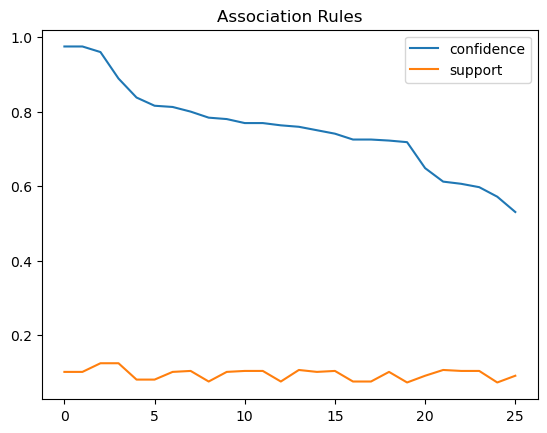

In [49]:
# Sort rules and plot confidence and support
sorted_rules=rules.sort_values(by=['confidence','support'],ascending=False).reset_index(drop=True)
sorted_rules[['confidence','support']].plot(title='Association Rules');

You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using the Pandas method `plot.scatter`.

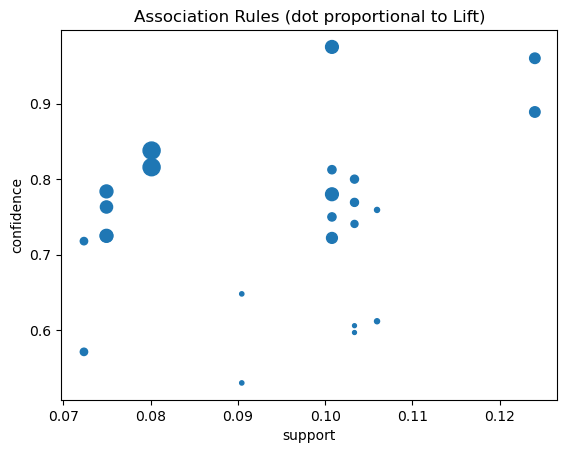

In [50]:
# 1.8 is chosen empirically to obtain the best graphical effect
# Scatter plot of rules with dot size proportional to lift
s = [1.8**n for n in rules.lift]
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

Finally, we draw a plot of a subset of the rules using the function `draw_graph`, provided in this package.

In [51]:
# Import draw_rules_graph function
from draw_rules_graph import draw_graph

# Display help for draw_graph
help(draw_graph)

Help on function draw_graph in module draw_rules_graph:

draw_graph(rules, rules_to_show=5)
    draws the rules as a graph linking antecedents and consequents
    "rule nodes" are yellow, with name "R<n>", "item nodes" are green
    arrows colors are different for each rule, and go from the antecedent(s)
    to the rule node and to the consequent(s)
    the "rules_to_show" parameter limits the rules to show to the initial
    part of the "rules" dataframe



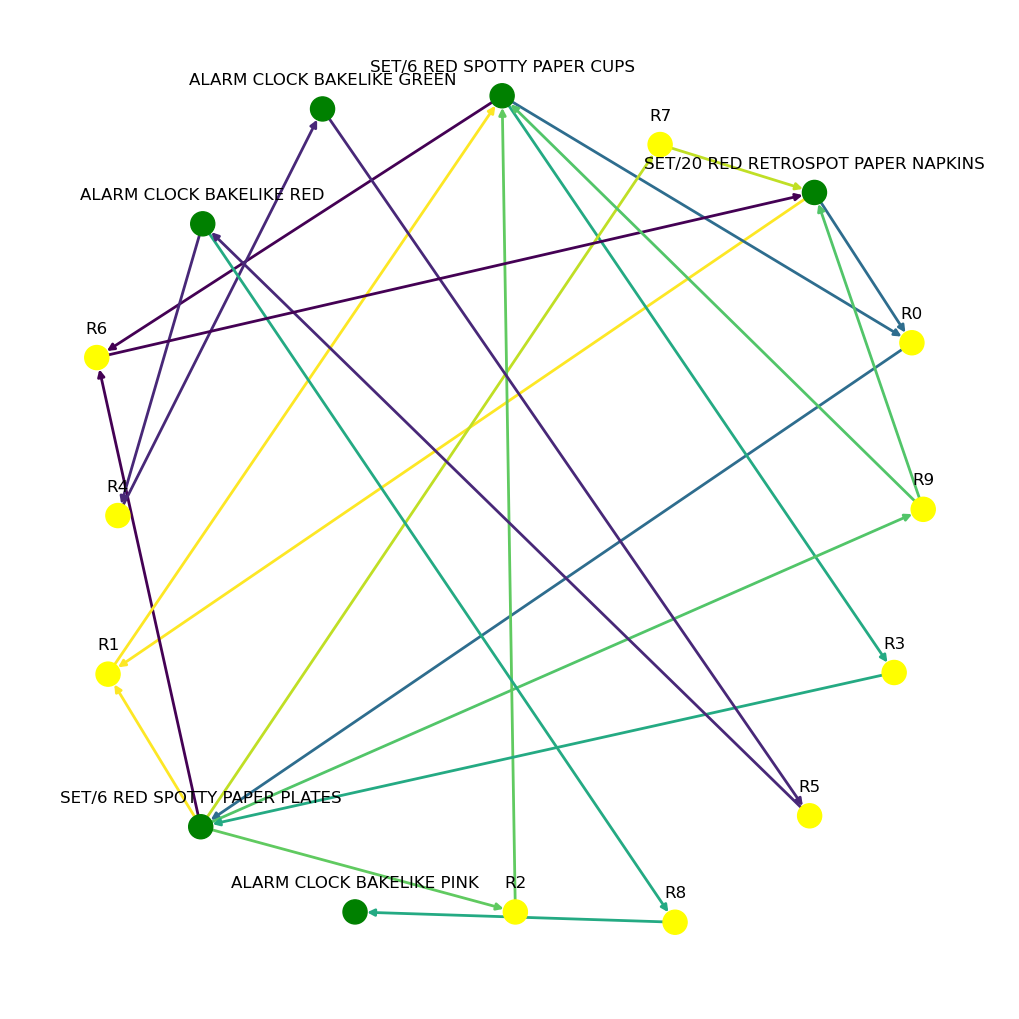

In [52]:
# Import matplotlib for plotting and enable inline display of plots
import matplotlib.pyplot as plt
%matplotlib inline

# Plot association rules graph with top 10 rules
plt.figure(figsize=(10,10))
draw_graph (sorted_rules, 10)  